In [246]:
from __future__ import print_function
import sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed = 0
np.random.seed(seed) # fix random seed
# tf.set_random_seed(seed)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina' #plot high-res img 

## Use entanglement spectra as input

In [258]:
# load the data by specifying the data type, interaction strengths and number of samples
def load_data(**args):
    # This is only useful if you run the en_spectrum.py script to generate your own data set
    d_type = args['type']
    L = int(args['len'])
    j1 = float(args['j1'])
    j2 = float(args['j2'])
    runs = int(para['run_1']) # number of samples generated
    loaded = np.load("data_set/j_"+str(j1)+"/1_en_spectrum_L="+str(L)+"_j="+str(j1)+".npz")
    # for ent_specta, the size is determined by the cut position
    # for the wavefunction, it's by the system size
    dim = loaded[d_type].shape
    x = np.zeros((runs, dim[0], dim[1]), dtype='float64')
    
    # load data for the phase 1
    for i in range(runs):
        filename = "data_set/j_"+str(j1)+"/"+str(i+1)+"_en_spectrum_L="+str(L)+"_j="+str(j1)+".npz"
        loaded = np.load(filename)
        if d_type == 'wave':
            wav = loaded[d_type]
            x[i] = np.multiply(wav, np.conj(wav)).real
        else:
            x[i] = loaded[d_type]
            
    p1 = np.concatenate((x[:])) 
    
    # load data for the phase 2
    runs = int(para['run_2'])    
    x = np.zeros((runs, dim[0], dim[1]), dtype='float64')
    for i in range(runs):
        filename = "data_set/j_"+str(j2)+"/"+str(i+1)+"_en_spectrum_L="+str(L)+"_j="+str(j2)+".npz"
        loaded = np.load(filename)
        if d_type == 'wave':
            wav = loaded[d_type]
            x[i] = np.multiply(wav, np.conj(wav)).real
        else:
            x[i] = loaded[d_type]
            
    p2 = np.concatenate((x[:])) 

    # cast the original data to single precision to speed up
    p1 = p1.astype('float32')
    p2 = p2.astype('float32')
    
    return p1, p2

In [279]:
para = {'type':'ent','len':'12', 'run_1':'16', 'run_2':'16', 'j1':'0.05', 'j2':'5.0'}

# load data according to parameters
p1, p2 = load_data(**para)

In [273]:
para = {'type':'ent','len':'12', 'run_1':'16', 'run_2':'12', 'j1':'0.05', 'j2':'1.5'}
# load data according to parameters
p1, p2 = load_data(**para)

In [268]:
p1 = np.concatenate((p1, pp1))
p2 = np.concatenate((p2, pp2))
print(p1.shape, p2.shape)

(45920, 128) (45920, 128)


In [339]:
from sklearn.model_selection import train_test_split

# processing data 
def data_pipeline(p1, p2, test_size = 0.2, encode = True):
    # combine entanglement spectrum of different system sizes with 2 labels
    num_classes = 2
    # create labels for the two phases
    l1 = np.ones(p1.shape[0],dtype=np.int8)
    l2 = np.zeros(p2.shape[0],dtype=np.int8)
    # combine labels and the data
    ph1 = np.column_stack((l1, p1))
    ph2 = np.column_stack((l2, p2))
    # train_test split
    dat = np.concatenate((ph1, ph2))
    X_train, X_test, Y_train, Y_test = train_test_split(dat[:,1:], dat[:,:1], test_size=test_size, random_state=1)
    # convert class vectors to binary class matrices
    if encode == True:
        Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
        Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)
    
    return X_train, X_test, Y_train, Y_test

# train test split
X_train, X_test, Y_train, Y_test = data_pipeline(p1, p2)

In [281]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

def create_model():
    # instantiate model
    model = Sequential()
    # add a normalization layer to improve robustness
    model.add(BatchNormalization(axis=-1, input_shape=(X_test.shape[1],)))
    # add a dense all-to-all relu layer
    model.add(Dense(400, activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(50, activation='relu'))
    # apply dropout with rate 0.4
    model.add(Dropout(0.4))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model with loss function and optimizer
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model

In [282]:
# training parameters
batch_size = 150
epochs = 14

from tensorflow.keras.callbacks import EarlyStopping
#early termination to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# create the deep neural net
model_DNN = create_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test), callbacks=[early_stopping])

Train on 41984 samples, validate on 10496 samples
Epoch 1/14
41984/41984 [==============================] - 3s 82us/sample - loss: 0.3368 - accuracy: 0.8453 - val_loss: 0.8858 - val_accuracy: 0.6798
Epoch 2/14
41984/41984 [==============================] - 2s 57us/sample - loss: 0.2366 - accuracy: 0.9015 - val_loss: 0.1994 - val_accuracy: 0.9184
Epoch 3/14
41984/41984 [==============================] - 2s 55us/sample - loss: 0.2182 - accuracy: 0.9100 - val_loss: 0.1980 - val_accuracy: 0.9175
Epoch 4/14
41984/41984 [==============================] - 2s 51us/sample - loss: 0.2013 - accuracy: 0.9183 - val_loss: 0.2089 - val_accuracy: 0.9128
Epoch 5/14
41984/41984 [==============================] - 2s 54us/sample - loss: 0.1996 - accuracy: 0.9178 - val_loss: 0.1928 - val_accuracy: 0.9195
Epoch 6/14
41984/41984 [==============================] - 2s 56us/sample - loss: 0.1929 - accuracy: 0.9218 - val_loss: 0.1951 - val_accuracy: 0.9180
Epoch 7/14
41984/41984 [==============================] 

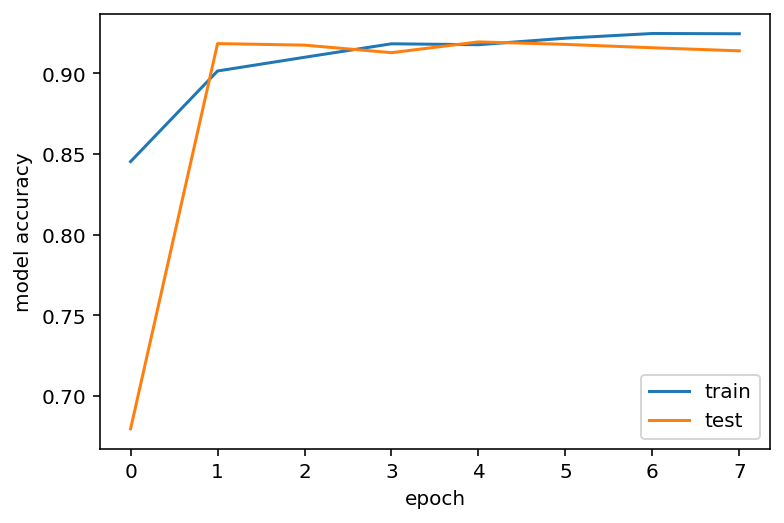

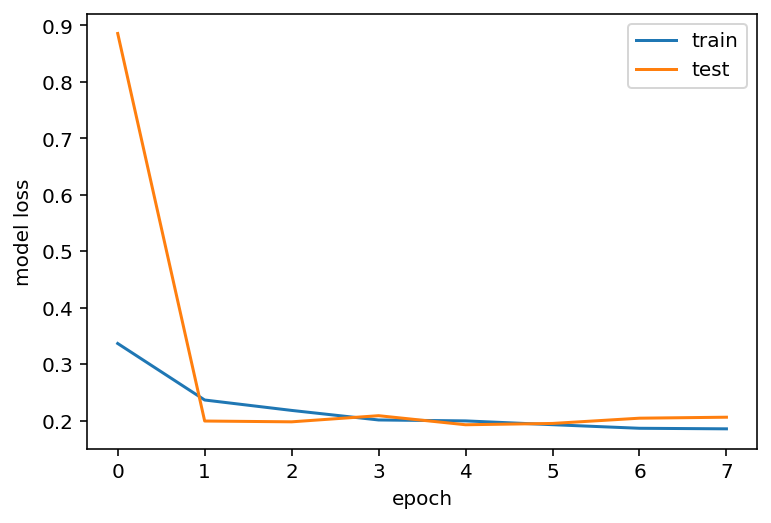

In [283]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [324]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2061660172667627
Test accuracy: 0.91396725


### Hyperparameters tuning
Use [Keras Tuner](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html) to search for the ideal parameters, including the discrete parameters such number of layers, number neurons in each layer etc., and continuous parameters like the dropout rate and  learning rate which is perphaps the most important one.

In [316]:
import kerastuner as kt
from kerastuner.tuners import Hyperband, BayesianOptimization


def create_model(hp):
    # instantiate model
    model = Sequential()
    # add a normalization layer to improve robustness
    model.add(BatchNormalization(axis=-1, input_shape=(X_test.shape[1],)))
    # add a dense all-to-all relu layer
#     for i in range(hp.Int('num_layers', 2, 6)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
#                                activation='relu'))
    model.add(Dense(units=hp.Int('layer_1_units',
                                        min_value=32,
                                        max_value=512,
                                        step=64),
                           activation='relu'))
    model.add(Dense(units=hp.Int('layer_2_units',
                                        min_value=32,
                                        max_value=512,
                                        step=64),
                           activation='relu'))
    model.add(Dropout(
      hp.Float('dropout_rate', 0, 0.5, step=0.1, default=0.5)))

    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model with loss function and optimizer    
    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
      loss='binary_crossentropy',
      metrics=['accuracy'])
    
    return model

In [318]:
import kerastuner as kt

tuner = kt.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=2,
    hyperband_iterations=2)

In [319]:
# using partial dateset for hp tuning
tuner.search(X_train[:16000], Y_train[:16000],
             epochs=2,
             validation_data=(X_test[:4000], Y_test[:4000]))

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:59 - loss: 0.7610 - accuracy: 0.34 - ETA: 36s - loss: 0.6827 - accuracy: 0.5365 - ETA: 19s - loss: 0.6810 - accuracy: 0.563 - ETA: 13s - loss: 0.6734 - accuracy: 0.569 - ETA: 10s - loss: 0.6603 - accuracy: 0.582 - ETA: 8s - loss: 0.6516 - accuracy: 0.598 - ETA: 7s - loss: 0.6396 - accuracy: 0.61 - ETA: 6s - loss: 0.6297 - accuracy: 0.62 - ETA: 5s - loss: 0.6304 - accuracy: 0.63 - ETA: 5s - loss: 0.6240 - accuracy: 0.63 - ETA: 4s - loss: 0.6222 - accuracy: 0.63 - ETA: 4s - loss: 0.6173 - accuracy: 0.64 - ETA: 4s - loss: 0.6132 - accuracy: 0.65 - ETA: 3s - loss: 0.6103 - accuracy: 0.65 - ETA: 3s - loss: 0.6069 - accuracy: 0.65 - ETA: 3s - loss: 0.6027 - accuracy: 0.65 - ETA: 3s - loss: 0.5977 - accuracy: 0.66 - ETA: 2s - loss: 0.5959 - accuracy: 0.66 - ETA: 2s - loss: 0.5941 - accuracy: 0.66 - ETA: 2s - loss: 0.5913 - accuracy: 0.66 - ETA: 2s - loss: 0.5886 - accuracy: 0.67 - 

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 7:56 - loss: 0.7437 - accuracy: 0.56 - ETA: 41s - loss: 0.6493 - accuracy: 0.6042 - ETA: 22s - loss: 0.6119 - accuracy: 0.649 - ETA: 16s - loss: 0.5893 - accuracy: 0.673 - ETA: 13s - loss: 0.5804 - accuracy: 0.678 - ETA: 11s - loss: 0.5704 - accuracy: 0.690 - ETA: 10s - loss: 0.5598 - accuracy: 0.697 - ETA: 8s - loss: 0.5467 - accuracy: 0.708 - ETA: 7s - loss: 0.5344 - accuracy: 0.72 - ETA: 6s - loss: 0.5192 - accuracy: 0.72 - ETA: 6s - loss: 0.5091 - accuracy: 0.73 - ETA: 5s - loss: 0.4937 - accuracy: 0.74 - ETA: 5s - loss: 0.4807 - accuracy: 0.75 - ETA: 4s - loss: 0.4750 - accuracy: 0.75 - ETA: 4s - loss: 0.4700 - accuracy: 0.76 - ETA: 3s - loss: 0.4628 - accuracy: 0.76 - ETA: 3s - loss: 0.4588 - accuracy: 0.77 - ETA: 3s - loss: 0.4521 - accuracy: 0.77 - ETA: 3s - loss: 0.4478 - accuracy: 0.77 - ETA: 3s - loss: 0.4472 - accuracy: 0.78 - ETA: 3s - loss: 0.4405 - accuracy: 0.7

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:09 - loss: 0.8166 - accuracy: 0.46 - ETA: 32s - loss: 1.8619 - accuracy: 0.5729 - ETA: 17s - loss: 1.3022 - accuracy: 0.608 - ETA: 12s - loss: 1.0667 - accuracy: 0.643 - ETA: 9s - loss: 0.9226 - accuracy: 0.664 - ETA: 8s - loss: 0.8294 - accuracy: 0.68 - ETA: 6s - loss: 0.7587 - accuracy: 0.70 - ETA: 6s - loss: 0.7113 - accuracy: 0.72 - ETA: 5s - loss: 0.6770 - accuracy: 0.73 - ETA: 4s - loss: 0.6439 - accuracy: 0.74 - ETA: 4s - loss: 0.6178 - accuracy: 0.75 - ETA: 4s - loss: 0.5906 - accuracy: 0.76 - ETA: 3s - loss: 0.5702 - accuracy: 0.77 - ETA: 3s - loss: 0.5529 - accuracy: 0.77 - ETA: 3s - loss: 0.5359 - accuracy: 0.78 - ETA: 3s - loss: 0.5241 - accuracy: 0.78 - ETA: 3s - loss: 0.5135 - accuracy: 0.79 - ETA: 2s - loss: 0.5074 - accuracy: 0.79 - ETA: 2s - loss: 0.5007 - accuracy: 0.79 - ETA: 2s - loss: 0.4891 - accuracy: 0.80 - ETA: 2s - loss: 0.4786 - accuracy: 0.80 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 7:24 - loss: 0.6860 - accuracy: 0.59 - ETA: 35s - loss: 0.6389 - accuracy: 0.6226 - ETA: 19s - loss: 0.6046 - accuracy: 0.666 - ETA: 14s - loss: 0.5965 - accuracy: 0.682 - ETA: 11s - loss: 0.5984 - accuracy: 0.676 - ETA: 9s - loss: 0.5895 - accuracy: 0.680 - ETA: 7s - loss: 0.5715 - accuracy: 0.69 - ETA: 6s - loss: 0.5610 - accuracy: 0.69 - ETA: 5s - loss: 0.5501 - accuracy: 0.70 - ETA: 5s - loss: 0.5411 - accuracy: 0.71 - ETA: 4s - loss: 0.5296 - accuracy: 0.72 - ETA: 4s - loss: 0.5258 - accuracy: 0.72 - ETA: 4s - loss: 0.5194 - accuracy: 0.73 - ETA: 3s - loss: 0.5142 - accuracy: 0.73 - ETA: 3s - loss: 0.5073 - accuracy: 0.74 - ETA: 3s - loss: 0.4997 - accuracy: 0.74 - ETA: 3s - loss: 0.4973 - accuracy: 0.74 - ETA: 3s - loss: 0.4931 - accuracy: 0.75 - ETA: 3s - loss: 0.4908 - accuracy: 0.75 - ETA: 2s - loss: 0.4836 - accuracy: 0.75 - ETA: 2s - loss: 0.4794 - accuracy: 0.76 - 

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:13 - loss: 0.7363 - accuracy: 0.43 - ETA: 25s - loss: 0.6685 - accuracy: 0.5417 - ETA: 14s - loss: 0.6391 - accuracy: 0.612 - ETA: 10s - loss: 0.6331 - accuracy: 0.619 - ETA: 8s - loss: 0.6235 - accuracy: 0.629 - ETA: 7s - loss: 0.6118 - accuracy: 0.64 - ETA: 6s - loss: 0.6030 - accuracy: 0.64 - ETA: 6s - loss: 0.5988 - accuracy: 0.65 - ETA: 5s - loss: 0.5899 - accuracy: 0.66 - ETA: 4s - loss: 0.5818 - accuracy: 0.67 - ETA: 4s - loss: 0.5802 - accuracy: 0.67 - ETA: 3s - loss: 0.5728 - accuracy: 0.68 - ETA: 3s - loss: 0.5674 - accuracy: 0.68 - ETA: 3s - loss: 0.5622 - accuracy: 0.69 - ETA: 3s - loss: 0.5554 - accuracy: 0.69 - ETA: 2s - loss: 0.5485 - accuracy: 0.70 - ETA: 2s - loss: 0.5412 - accuracy: 0.70 - ETA: 2s - loss: 0.5328 - accuracy: 0.71 - ETA: 2s - loss: 0.5288 - accuracy: 0.71 - ETA: 2s - loss: 0.5246 - accuracy: 0.71 - ETA: 2s - loss: 0.5202 - accuracy: 0.72 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 3/4
16000/16000 [==============================] - ETA: 6:36 - loss: 0.8576 - accuracy: 0.50 - ETA: 34s - loss: 0.6943 - accuracy: 0.5990 - ETA: 18s - loss: 0.6641 - accuracy: 0.631 - ETA: 13s - loss: 0.6369 - accuracy: 0.649 - ETA: 10s - loss: 0.6113 - accuracy: 0.666 - ETA: 8s - loss: 0.5923 - accuracy: 0.678 - ETA: 7s - loss: 0.5759 - accuracy: 0.69 - ETA: 6s - loss: 0.5637 - accuracy: 0.70 - ETA: 6s - loss: 0.5514 - accuracy: 0.70 - ETA: 5s - loss: 0.5391 - accuracy: 0.71 - ETA: 5s - loss: 0.5283 - accuracy: 0.72 - ETA: 4s - loss: 0.5139 - accuracy: 0.73 - ETA: 4s - loss: 0.5093 - accuracy: 0.73 - ETA: 4s - loss: 0.5042 - accuracy: 0.73 - ETA: 3s - loss: 0.4966 - accuracy: 0.74 - ETA: 3s - loss: 0.4940 - accuracy: 0.74 - ETA: 3s - loss: 0.4869 - accuracy: 0.75 - ETA: 3s - loss: 0.4798 - accuracy: 0.75 - ETA: 3s - loss: 0.4724 - accuracy: 0.76 - ETA: 2s - loss: 0.4673 - accuracy: 0.76 - ETA: 2s - loss: 0.4645 - accuracy: 0.76 - 

Train on 16000 samples, validate on 4000 samples
Epoch 3/4
16000/16000 [==============================] - ETA: 6:46 - loss: 0.6557 - accuracy: 0.62 - ETA: 32s - loss: 0.6781 - accuracy: 0.5625 - ETA: 17s - loss: 0.6540 - accuracy: 0.602 - ETA: 12s - loss: 0.6519 - accuracy: 0.608 - ETA: 9s - loss: 0.6456 - accuracy: 0.613 - ETA: 8s - loss: 0.6302 - accuracy: 0.63 - ETA: 6s - loss: 0.6279 - accuracy: 0.63 - ETA: 6s - loss: 0.6193 - accuracy: 0.64 - ETA: 5s - loss: 0.6137 - accuracy: 0.64 - ETA: 4s - loss: 0.6105 - accuracy: 0.64 - ETA: 4s - loss: 0.6017 - accuracy: 0.65 - ETA: 4s - loss: 0.5985 - accuracy: 0.65 - ETA: 3s - loss: 0.5920 - accuracy: 0.66 - ETA: 3s - loss: 0.5852 - accuracy: 0.67 - ETA: 3s - loss: 0.5796 - accuracy: 0.67 - ETA: 3s - loss: 0.5767 - accuracy: 0.67 - ETA: 2s - loss: 0.5699 - accuracy: 0.68 - ETA: 2s - loss: 0.5656 - accuracy: 0.68 - ETA: 2s - loss: 0.5589 - accuracy: 0.69 - ETA: 2s - loss: 0.5534 - accuracy: 0.69 - ETA: 2s - loss: 0.5497 - accuracy: 0.70 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - ETA: 6:35 - loss: 0.7001 - accuracy: 0.53 - ETA: 31s - loss: 5.4502 - accuracy: 0.5817 - ETA: 17s - loss: 6.5366 - accuracy: 0.540 - ETA: 12s - loss: 7.1049 - accuracy: 0.514 - ETA: 9s - loss: 7.3701 - accuracy: 0.502 - ETA: 8s - loss: 7.4655 - accuracy: 0.50 - ETA: 7s - loss: 7.5512 - accuracy: 0.49 - ETA: 6s - loss: 7.6556 - accuracy: 0.49 - ETA: 5s - loss: 7.6544 - accuracy: 0.49 - ETA: 4s - loss: 7.7154 - accuracy: 0.49 - ETA: 4s - loss: 7.7343 - accuracy: 0.48 - ETA: 4s - loss: 7.6795 - accuracy: 0.49 - ETA: 3s - loss: 7.7236 - accuracy: 0.49 - ETA: 3s - loss: 7.7175 - accuracy: 0.49 - ETA: 3s - loss: 7.6693 - accuracy: 0.49 - ETA: 3s - loss: 7.6649 - accuracy: 0.49 - ETA: 2s - loss: 7.6691 - accuracy: 0.49 - ETA: 2s - loss: 7.6881 - accuracy: 0.49 - ETA: 2s - loss: 7.6810 - accuracy: 0.49 - ETA: 2s - loss: 7.6973 - accuracy: 0.49 - ETA: 2s - loss: 7.6948 - accuracy: 0.49 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - ETA: 6:35 - loss: 0.6729 - accuracy: 0.56 - ETA: 41s - loss: 0.6834 - accuracy: 0.5688 - ETA: 22s - loss: 0.6696 - accuracy: 0.582 - ETA: 16s - loss: 0.6493 - accuracy: 0.615 - ETA: 13s - loss: 0.6334 - accuracy: 0.624 - ETA: 11s - loss: 0.6223 - accuracy: 0.636 - ETA: 9s - loss: 0.6162 - accuracy: 0.643 - ETA: 8s - loss: 0.6066 - accuracy: 0.65 - ETA: 7s - loss: 0.5994 - accuracy: 0.66 - ETA: 6s - loss: 0.5939 - accuracy: 0.66 - ETA: 6s - loss: 0.5864 - accuracy: 0.67 - ETA: 5s - loss: 0.5811 - accuracy: 0.68 - ETA: 5s - loss: 0.5745 - accuracy: 0.68 - ETA: 4s - loss: 0.5720 - accuracy: 0.68 - ETA: 4s - loss: 0.5650 - accuracy: 0.69 - ETA: 4s - loss: 0.5605 - accuracy: 0.69 - ETA: 4s - loss: 0.5534 - accuracy: 0.70 - ETA: 4s - loss: 0.5486 - accuracy: 0.70 - ETA: 3s - loss: 0.5447 - accuracy: 0.71 - ETA: 3s - loss: 0.5420 - accuracy: 0.71 - ETA: 3s - loss: 0.5384 - accuracy: 0.71 

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - ETA: 6:25 - loss: 0.8514 - accuracy: 0.37 - ETA: 30s - loss: 0.7478 - accuracy: 0.4976 - ETA: 17s - loss: 0.7239 - accuracy: 0.527 - ETA: 12s - loss: 0.7050 - accuracy: 0.550 - ETA: 10s - loss: 0.6907 - accuracy: 0.574 - ETA: 8s - loss: 0.6783 - accuracy: 0.586 - ETA: 7s - loss: 0.6658 - accuracy: 0.59 - ETA: 6s - loss: 0.6570 - accuracy: 0.60 - ETA: 5s - loss: 0.6490 - accuracy: 0.61 - ETA: 5s - loss: 0.6429 - accuracy: 0.61 - ETA: 4s - loss: 0.6415 - accuracy: 0.62 - ETA: 4s - loss: 0.6341 - accuracy: 0.62 - ETA: 4s - loss: 0.6269 - accuracy: 0.63 - ETA: 3s - loss: 0.6229 - accuracy: 0.63 - ETA: 3s - loss: 0.6168 - accuracy: 0.64 - ETA: 3s - loss: 0.6106 - accuracy: 0.65 - ETA: 3s - loss: 0.6063 - accuracy: 0.65 - ETA: 2s - loss: 0.6008 - accuracy: 0.66 - ETA: 2s - loss: 0.5948 - accuracy: 0.66 - ETA: 2s - loss: 0.5888 - accuracy: 0.67 - ETA: 2s - loss: 0.5831 - accuracy: 0.67 - 

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:52 - loss: 0.8140 - accuracy: 0.40 - ETA: 39s - loss: 0.6282 - accuracy: 0.6335 - ETA: 21s - loss: 0.5957 - accuracy: 0.669 - ETA: 14s - loss: 0.5629 - accuracy: 0.692 - ETA: 11s - loss: 0.5543 - accuracy: 0.698 - ETA: 9s - loss: 0.5357 - accuracy: 0.709 - ETA: 8s - loss: 0.5102 - accuracy: 0.73 - ETA: 7s - loss: 0.4925 - accuracy: 0.74 - ETA: 6s - loss: 0.4752 - accuracy: 0.75 - ETA: 6s - loss: 0.4661 - accuracy: 0.76 - ETA: 5s - loss: 0.4498 - accuracy: 0.77 - ETA: 5s - loss: 0.4424 - accuracy: 0.77 - ETA: 4s - loss: 0.4486 - accuracy: 0.77 - ETA: 4s - loss: 0.4568 - accuracy: 0.77 - ETA: 4s - loss: 0.4560 - accuracy: 0.77 - ETA: 4s - loss: 0.4531 - accuracy: 0.78 - ETA: 3s - loss: 0.4514 - accuracy: 0.78 - ETA: 3s - loss: 0.4461 - accuracy: 0.78 - ETA: 3s - loss: 0.4428 - accuracy: 0.78 - ETA: 3s - loss: 0.4381 - accuracy: 0.79 - ETA: 3s - loss: 0.4327 - accuracy: 0.79 - 

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:19 - loss: 0.7443 - accuracy: 0.53 - ETA: 28s - loss: 0.7150 - accuracy: 0.6473 - ETA: 15s - loss: 0.6083 - accuracy: 0.702 - ETA: 10s - loss: 0.5499 - accuracy: 0.733 - ETA: 8s - loss: 0.5208 - accuracy: 0.749 - ETA: 6s - loss: 0.5112 - accuracy: 0.75 - ETA: 5s - loss: 0.4870 - accuracy: 0.77 - ETA: 4s - loss: 0.4805 - accuracy: 0.77 - ETA: 4s - loss: 0.4666 - accuracy: 0.78 - ETA: 3s - loss: 0.4603 - accuracy: 0.78 - ETA: 3s - loss: 0.4538 - accuracy: 0.78 - ETA: 3s - loss: 0.4445 - accuracy: 0.79 - ETA: 2s - loss: 0.4369 - accuracy: 0.79 - ETA: 2s - loss: 0.4315 - accuracy: 0.80 - ETA: 2s - loss: 0.4231 - accuracy: 0.80 - ETA: 2s - loss: 0.4158 - accuracy: 0.80 - ETA: 2s - loss: 0.4129 - accuracy: 0.81 - ETA: 2s - loss: 0.4089 - accuracy: 0.81 - ETA: 1s - loss: 0.4039 - accuracy: 0.81 - ETA: 1s - loss: 0.3990 - accuracy: 0.81 - ETA: 1s - loss: 0.3948 - accuracy: 0.82 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:39 - loss: 1.0271 - accuracy: 0.43 - ETA: 29s - loss: 1.0881 - accuracy: 0.5893 - ETA: 16s - loss: 0.8501 - accuracy: 0.638 - ETA: 11s - loss: 0.7357 - accuracy: 0.682 - ETA: 9s - loss: 0.6712 - accuracy: 0.703 - ETA: 7s - loss: 0.6267 - accuracy: 0.72 - ETA: 6s - loss: 0.6002 - accuracy: 0.73 - ETA: 5s - loss: 0.5810 - accuracy: 0.74 - ETA: 5s - loss: 0.5559 - accuracy: 0.75 - ETA: 4s - loss: 0.5353 - accuracy: 0.76 - ETA: 4s - loss: 0.5176 - accuracy: 0.77 - ETA: 3s - loss: 0.5041 - accuracy: 0.78 - ETA: 3s - loss: 0.4947 - accuracy: 0.78 - ETA: 3s - loss: 0.4847 - accuracy: 0.79 - ETA: 3s - loss: 0.4809 - accuracy: 0.79 - ETA: 2s - loss: 0.4718 - accuracy: 0.79 - ETA: 2s - loss: 0.4629 - accuracy: 0.79 - ETA: 2s - loss: 0.4579 - accuracy: 0.80 - ETA: 2s - loss: 0.4511 - accuracy: 0.80 - ETA: 2s - loss: 0.4469 - accuracy: 0.80 - ETA: 2s - loss: 0.4444 - accuracy: 0.80 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:12 - loss: 0.7550 - accuracy: 0.46 - ETA: 32s - loss: 7.1918 - accuracy: 0.4922 - ETA: 17s - loss: 7.7433 - accuracy: 0.475 - ETA: 12s - loss: 7.7998 - accuracy: 0.478 - ETA: 10s - loss: 7.8412 - accuracy: 0.478 - ETA: 8s - loss: 7.8942 - accuracy: 0.477 - ETA: 7s - loss: 7.8694 - accuracy: 0.48 - ETA: 6s - loss: 7.7986 - accuracy: 0.48 - ETA: 5s - loss: 7.8029 - accuracy: 0.48 - ETA: 5s - loss: 7.8734 - accuracy: 0.48 - ETA: 4s - loss: 7.8742 - accuracy: 0.48 - ETA: 4s - loss: 7.8876 - accuracy: 0.48 - ETA: 4s - loss: 7.7934 - accuracy: 0.48 - ETA: 3s - loss: 7.7530 - accuracy: 0.49 - ETA: 3s - loss: 7.7553 - accuracy: 0.49 - ETA: 3s - loss: 7.7196 - accuracy: 0.49 - ETA: 3s - loss: 7.7387 - accuracy: 0.49 - ETA: 3s - loss: 7.7498 - accuracy: 0.49 - ETA: 2s - loss: 7.7333 - accuracy: 0.49 - ETA: 2s - loss: 7.7285 - accuracy: 0.49 - ETA: 2s - loss: 7.7456 - accuracy: 0.49 - 

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - ETA: 6:55 - loss: 0.8058 - accuracy: 0.56 - ETA: 33s - loss: 0.5962 - accuracy: 0.6899 - ETA: 17s - loss: 0.5827 - accuracy: 0.705 - ETA: 12s - loss: 0.5838 - accuracy: 0.704 - ETA: 10s - loss: 0.5671 - accuracy: 0.711 - ETA: 8s - loss: 0.5433 - accuracy: 0.726 - ETA: 7s - loss: 0.5246 - accuracy: 0.74 - ETA: 6s - loss: 0.5068 - accuracy: 0.75 - ETA: 6s - loss: 0.5024 - accuracy: 0.75 - ETA: 5s - loss: 0.5001 - accuracy: 0.75 - ETA: 5s - loss: 0.4885 - accuracy: 0.75 - ETA: 4s - loss: 0.4795 - accuracy: 0.76 - ETA: 4s - loss: 0.4711 - accuracy: 0.77 - ETA: 4s - loss: 0.4600 - accuracy: 0.77 - ETA: 3s - loss: 0.4492 - accuracy: 0.78 - ETA: 3s - loss: 0.4448 - accuracy: 0.78 - ETA: 3s - loss: 0.4377 - accuracy: 0.78 - ETA: 3s - loss: 0.4319 - accuracy: 0.79 - ETA: 2s - loss: 0.4247 - accuracy: 0.79 - ETA: 2s - loss: 0.4188 - accuracy: 0.79 - ETA: 2s - loss: 0.4226 - accuracy: 0.79 - 

Train on 16000 samples, validate on 4000 samples
Epoch 3/4
16000/16000 [==============================] - ETA: 6:31 - loss: 0.7784 - accuracy: 0.53 - ETA: 37s - loss: 0.6524 - accuracy: 0.6108 - ETA: 20s - loss: 0.6094 - accuracy: 0.642 - ETA: 14s - loss: 0.5972 - accuracy: 0.657 - ETA: 11s - loss: 0.5634 - accuracy: 0.689 - ETA: 9s - loss: 0.5350 - accuracy: 0.706 - ETA: 8s - loss: 0.5091 - accuracy: 0.72 - ETA: 7s - loss: 0.4941 - accuracy: 0.73 - ETA: 6s - loss: 0.4853 - accuracy: 0.74 - ETA: 6s - loss: 0.4801 - accuracy: 0.74 - ETA: 5s - loss: 0.4706 - accuracy: 0.75 - ETA: 5s - loss: 0.4683 - accuracy: 0.75 - ETA: 4s - loss: 0.4606 - accuracy: 0.76 - ETA: 4s - loss: 0.4555 - accuracy: 0.76 - ETA: 4s - loss: 0.4480 - accuracy: 0.77 - ETA: 4s - loss: 0.4443 - accuracy: 0.77 - ETA: 3s - loss: 0.4371 - accuracy: 0.77 - ETA: 3s - loss: 0.4311 - accuracy: 0.78 - ETA: 3s - loss: 0.4270 - accuracy: 0.78 - ETA: 3s - loss: 0.4219 - accuracy: 0.79 - ETA: 3s - loss: 0.4226 - accuracy: 0.79 - 

Train on 16000 samples, validate on 4000 samples
Epoch 3/4
16000/16000 [==============================] - ETA: 6:16 - loss: 0.7932 - accuracy: 0.50 - ETA: 32s - loss: 0.6671 - accuracy: 0.6328 - ETA: 17s - loss: 0.6529 - accuracy: 0.635 - ETA: 12s - loss: 0.6145 - accuracy: 0.665 - ETA: 9s - loss: 0.5834 - accuracy: 0.691 - ETA: 8s - loss: 0.5701 - accuracy: 0.70 - ETA: 6s - loss: 0.5510 - accuracy: 0.71 - ETA: 6s - loss: 0.5361 - accuracy: 0.72 - ETA: 5s - loss: 0.5206 - accuracy: 0.73 - ETA: 5s - loss: 0.4988 - accuracy: 0.74 - ETA: 4s - loss: 0.4904 - accuracy: 0.75 - ETA: 4s - loss: 0.4859 - accuracy: 0.75 - ETA: 3s - loss: 0.4720 - accuracy: 0.76 - ETA: 3s - loss: 0.4716 - accuracy: 0.77 - ETA: 3s - loss: 0.4653 - accuracy: 0.77 - ETA: 3s - loss: 0.4574 - accuracy: 0.77 - ETA: 3s - loss: 0.4528 - accuracy: 0.77 - ETA: 2s - loss: 0.4441 - accuracy: 0.78 - ETA: 2s - loss: 0.4409 - accuracy: 0.78 - ETA: 2s - loss: 0.4380 - accuracy: 0.78 - ETA: 2s - loss: 0.4303 - accuracy: 0.79 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - ETA: 6:20 - loss: 0.7808 - accuracy: 0.59 - ETA: 26s - loss: 0.7395 - accuracy: 0.5604 - ETA: 14s - loss: 0.6961 - accuracy: 0.601 - ETA: 10s - loss: 0.6735 - accuracy: 0.610 - ETA: 7s - loss: 0.6524 - accuracy: 0.626 - ETA: 6s - loss: 0.6422 - accuracy: 0.63 - ETA: 5s - loss: 0.6219 - accuracy: 0.64 - ETA: 4s - loss: 0.6105 - accuracy: 0.66 - ETA: 4s - loss: 0.5957 - accuracy: 0.67 - ETA: 3s - loss: 0.5831 - accuracy: 0.67 - ETA: 3s - loss: 0.5726 - accuracy: 0.68 - ETA: 3s - loss: 0.5642 - accuracy: 0.69 - ETA: 2s - loss: 0.5547 - accuracy: 0.69 - ETA: 2s - loss: 0.5432 - accuracy: 0.70 - ETA: 2s - loss: 0.5346 - accuracy: 0.71 - ETA: 2s - loss: 0.5248 - accuracy: 0.72 - ETA: 2s - loss: 0.5182 - accuracy: 0.72 - ETA: 2s - loss: 0.5137 - accuracy: 0.73 - ETA: 1s - loss: 0.5056 - accuracy: 0.73 - ETA: 1s - loss: 0.4969 - accuracy: 0.74 - ETA: 1s - loss: 0.4938 - accuracy: 0.74 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - ETA: 6:34 - loss: 0.7281 - accuracy: 0.46 - ETA: 31s - loss: 3.2484 - accuracy: 0.6466 - ETA: 17s - loss: 3.6588 - accuracy: 0.636 - ETA: 12s - loss: 3.1628 - accuracy: 0.663 - ETA: 9s - loss: 2.6928 - accuracy: 0.664 - ETA: 8s - loss: 2.2761 - accuracy: 0.68 - ETA: 6s - loss: 1.9950 - accuracy: 0.69 - ETA: 6s - loss: 1.7916 - accuracy: 0.70 - ETA: 5s - loss: 1.6359 - accuracy: 0.71 - ETA: 4s - loss: 1.4974 - accuracy: 0.72 - ETA: 4s - loss: 1.3970 - accuracy: 0.73 - ETA: 4s - loss: 1.3048 - accuracy: 0.74 - ETA: 3s - loss: 1.2314 - accuracy: 0.75 - ETA: 3s - loss: 1.1657 - accuracy: 0.76 - ETA: 3s - loss: 1.1078 - accuracy: 0.76 - ETA: 3s - loss: 1.0625 - accuracy: 0.76 - ETA: 2s - loss: 1.0230 - accuracy: 0.77 - ETA: 2s - loss: 0.9855 - accuracy: 0.77 - ETA: 2s - loss: 0.9491 - accuracy: 0.78 - ETA: 2s - loss: 0.9240 - accuracy: 0.78 - ETA: 2s - loss: 0.8977 - accuracy: 0.78 - ET

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - ETA: 6:43 - loss: 0.7321 - accuracy: 0.59 - ETA: 42s - loss: 4.4453 - accuracy: 0.5844 - ETA: 23s - loss: 4.3540 - accuracy: 0.629 - ETA: 16s - loss: 4.6595 - accuracy: 0.632 - ETA: 12s - loss: 4.7454 - accuracy: 0.641 - ETA: 10s - loss: 4.7007 - accuracy: 0.654 - ETA: 9s - loss: 4.8414 - accuracy: 0.650 - ETA: 8s - loss: 5.0264 - accuracy: 0.64 - ETA: 7s - loss: 5.0358 - accuracy: 0.64 - ETA: 6s - loss: 5.0510 - accuracy: 0.64 - ETA: 6s - loss: 4.9332 - accuracy: 0.65 - ETA: 6s - loss: 4.8668 - accuracy: 0.66 - ETA: 5s - loss: 4.9955 - accuracy: 0.65 - ETA: 5s - loss: 5.1031 - accuracy: 0.65 - ETA: 5s - loss: 5.3070 - accuracy: 0.63 - ETA: 4s - loss: 5.4239 - accuracy: 0.63 - ETA: 4s - loss: 5.5413 - accuracy: 0.62 - ETA: 4s - loss: 5.6454 - accuracy: 0.61 - ETA: 4s - loss: 5.7257 - accuracy: 0.61 - ETA: 3s - loss: 5.7842 - accuracy: 0.61 - ETA: 3s - loss: 5.7372 - accuracy: 0.61 

INFO:tensorflow:Oracle triggered exit


In [320]:
hp = tuner.get_best_hyperparameters(1)[0]
print(hp.values)

{'layer_1_units': 160, 'layer_2_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.0008103522407323546, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


### Re-train the model with optimized hyper-parameters
Now that we've found the (hopefully) best hyper parameters, let's retrain the model to see its performance

In [321]:
def create_model_hp():
    # instantiate model
    model = Sequential()
    # add a normalization layer to improve robustness
    model.add(BatchNormalization(axis=-1, input_shape=(X_test.shape[1],)))
    # add a dense all-to-all relu layer
    model.add(Dense(160, activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model with loss function and optimizer
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00081),
                  metrics=['accuracy'])
    
    return model

In [322]:
# training parameters
batch_size = 150
epochs = 14

# create the deep neural net
model_hp = create_model_hp()

# train DNN and store training info in history
history = model_hp.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test), callbacks=[early_stopping])

Train on 41984 samples, validate on 10496 samples
Epoch 1/14
41984/41984 [==============================] - ETA: 4:32 - loss: 0.8316 - accuracy: 0.44 - ETA: 40s - loss: 0.7402 - accuracy: 0.5229 - ETA: 20s - loss: 0.6929 - accuracy: 0.577 - ETA: 14s - loss: 0.6607 - accuracy: 0.611 - ETA: 11s - loss: 0.6421 - accuracy: 0.631 - ETA: 8s - loss: 0.6150 - accuracy: 0.655 - ETA: 7s - loss: 0.6030 - accuracy: 0.66 - ETA: 6s - loss: 0.5830 - accuracy: 0.68 - ETA: 5s - loss: 0.5696 - accuracy: 0.69 - ETA: 4s - loss: 0.5578 - accuracy: 0.69 - ETA: 4s - loss: 0.5470 - accuracy: 0.70 - ETA: 3s - loss: 0.5333 - accuracy: 0.71 - ETA: 3s - loss: 0.5257 - accuracy: 0.72 - ETA: 3s - loss: 0.5149 - accuracy: 0.72 - ETA: 3s - loss: 0.5050 - accuracy: 0.73 - ETA: 2s - loss: 0.4960 - accuracy: 0.74 - ETA: 2s - loss: 0.4878 - accuracy: 0.74 - ETA: 2s - loss: 0.4790 - accuracy: 0.75 - ETA: 2s - loss: 0.4715 - accuracy: 0.75 - ETA: 2s - loss: 0.4650 - accuracy: 0.76 - ETA: 1s - loss: 0.4585 - accuracy: 0.76 

Test loss: 0.19571365803343857
Test accuracy: 0.9210175


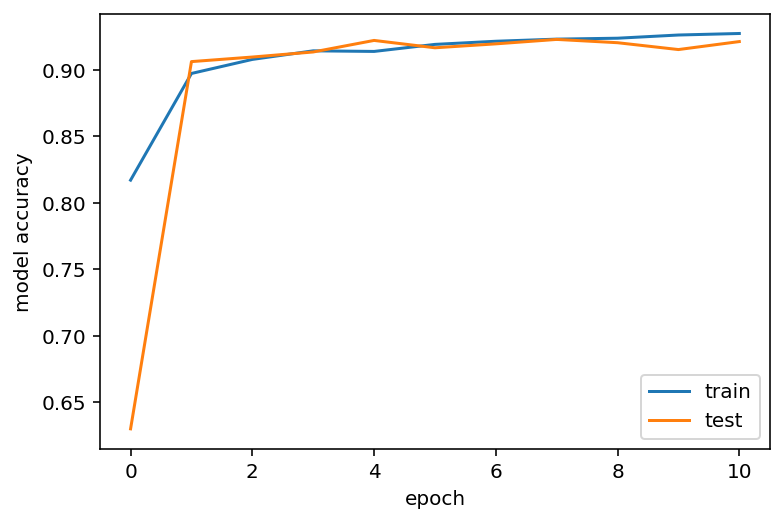

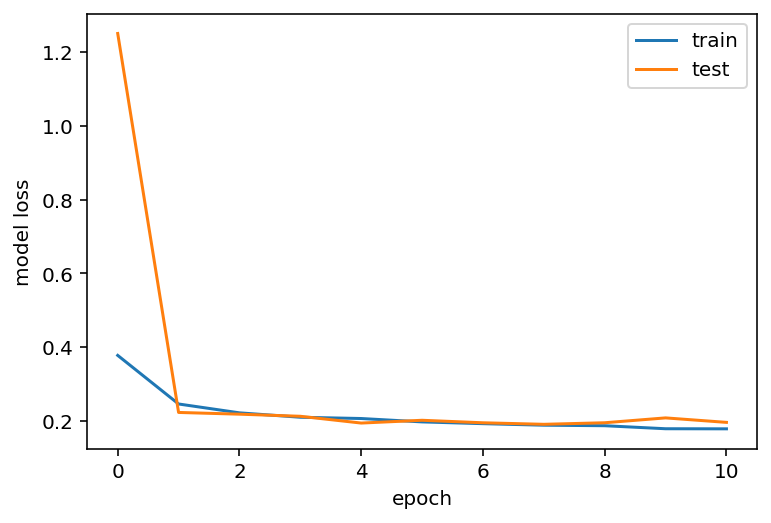

In [323]:
# evaluate model
new_score = model_hp.evaluate(X_test, Y_test, verbose=0)

# print performance
print('Test loss:', new_score[0])
print('Test accuracy:', new_score[1])

# look into training history
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

We can see a slight improve of accurary over the old model and a reduction in the gap between the test and training data

### Load other data set with different $j$ to see how well the network generalizes
According to the energy level statistics, the critical point occurs around $j_c\approx 0.23$.
So we use different $j$ values as data set to see how our network works.

In [345]:
para = {'type':'ent','len':'12', 'run_1':'8', 'run_2':'8', 'j1':'0.1', 'j2':'1.5'}

# load data according to parameters
p1, p2 = load_data(**para)

# train test split
X_train, X_test, Y_train, Y_test = data_pipeline(p1, p2, 0.99)
print(X_train.shape, X_test.shape)

(262, 128) (25978, 128)


In [346]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=0)
score_hp = model_hp.evaluate(X_test, Y_test, verbose=0)
# print performance
print('Test loss:', score[0], score_hp[0])
print('Test accuracy:', score[1], score_hp[1])

Test loss: 0.5174471297443248 0.57263532362833
Test accuracy: 0.76187545 0.7489029


In [347]:
Y_pred = model_hp.predict_classes(X_test, verbose=0)

In [348]:
# reverse transform the one-hot matrix to 1-D list
_, _, _, Y_test = data_pipeline(p1, p2, 0.99, encode = False)
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y_test)
Y_test = enc.transform(Y_test).toarray()

Y_true = enc.inverse_transform(Y_test)
Y_true = Y_true.flatten()

In [350]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_true, Y_pred)
print(cm)

[[ 8132  4853]
 [ 1670 11323]]


According to the convention of sci-kit learn, the $c_{0,0}$ component of the matrix represents the true negatives. So the total positive rate is

In [353]:
cm[1,1]+cm[1,0]

12993

In [354]:
para = {'type':'ent','len':'12', 'run_1':'4', 'run_2':'4', 'j1':'0.15', 'j2':'0.31'}

# load data according to parameters
p1, p2 = load_data(**para)

# train test split
X_train, X_test, Y_train, Y_test = data_pipeline(p1, p2, 0.99)
print(X_train.shape, X_test.shape)

(131, 128) (12989, 128)


In [355]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=0)
score_hp = model_hp.evaluate(X_test, Y_test, verbose=0)
# print performance
print('Test loss:', score[0], score_hp[0])
print('Test accuracy:', score[1], score_hp[1])

Test loss: 1.6878004383752652 1.891175561821647
Test accuracy: 0.50642854 0.51343447


### Using critical data set for identifying critical points
According to the energy level statistics, the critical point occurs around $j_c\approx 0.23$.
To benchmark this result, we use $j=0.21$ and $j=0.25$ as data set close to the critical point to see how our network works.

In [331]:
para = {'type':'ent','len':'12', 'run_1':'8', 'run_2':'8', 'j1':'0.21', 'j2':'0.25'}
p1, p2 = load_data(**para)

In [332]:
# train test split
X_train, X_test, Y_train, Y_test = data_pipeline(p1, p2, 0.99)
print(X_train.shape, X_test.shape)

(262, 128) (25978, 128)


In [333]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.6815702211444763
Test accuracy: 0.48594964


In [334]:
# evaluate model
score_hp = model_hp.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score_hp[0])
print('Test accuracy:', score_hp[1])


Test loss: 1.9061038626636255
Test accuracy: 0.49264762
